In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import os, sys, cv2, pickle
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
from progressbar import ProgressBar
import random, itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, make_scorer, hamming_loss

from keras.utils import to_categorical
from keras.models import Model

#import tensorflow as tf
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)

#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Using TensorFlow backend.


# Load dataset train

In [3]:
train = pd.read_csv("../data/train.csv", sep=",")
test = pd.read_csv("../data/test.csv", sep=",")
dig_mnist = pd.read_csv("../data/Dig-MNIST.csv", sep=",")
sample_submission = pd.read_csv("../data/sample_submission.csv", sep=",")

# Get Class to create array for model

In [4]:
class Create_Array:
    def __init__(self, data, random_sample, random_state):
        self.random_sample = random_sample
        self.random_state = random_state
        if random_sample == 1: self.data = data
        else:
            train_X, test_X, train_y, test_y = \
            train_test_split(data, data.label, test_size=random_sample, random_state=random_state, stratify=data.label)
            test_X['label'] = test_y
            self.data = test_X.reset_index(drop="index")
    def split_data(self, test_size, to_category):
        self.test_size = test_size
        train_X, test_X, train_y, test_y = \
        train_test_split(self.data.drop(columns="label"), self.data.label, test_size=test_size, random_state=self.random_state, stratify=self.data.label)
        train_X = train_X.reset_index(drop='index')
        self.train_X = self.change_format_X(train_X)
        test_X = test_X.reset_index(drop='index')
        self.test_X = self.change_format_X(test_X)
        train_y = train_y.reset_index(drop='index')
        self.train_y = self.change_format_y(train_y, to_category)
        test_y = test_y.reset_index(drop='index')
        self.test_y = self.change_format_y(test_y, to_category)
    def get_pie_chart(self, figsize):
        label_dict = dict()
        label_count = self.data.label.value_counts()
        for k in label_count.index:
            label_dict[label_count.index[k]] = label_count[k]
        
        def func(pct, allvals):
            absolute = int(pct/100.*np.sum(allvals))
            return "{:0.0f}\n{:0.2f} %".format(absolute, pct)
        
        data = list(label_dict.values())
        
        fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))
        wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                          textprops=dict(color="w"))
        ax.legend(wedges, label_dict.keys(),
                  title="Labels",
                  loc="center left",
                  bbox_to_anchor=(1, 0, 0.5, 1))
        return fig
    def show_one_image(self, figsize):
        plt.figure(figsize=figsize)
        ind = random.sample(k=1, population=set(self.data.index))
        img = self.data.loc[ind[0]]["pixel0":].values.reshape(28,28)
        plt.imshow(img)
        plt.title("label : {}".format(self.data.loc[ind[0]]["label"]))
        return plt
    def show_multiple_images(self, seed, figsize):
        random.seed(seed)
        num_dict = dict()
        for num in range(10):
            ind = random.sample(k=1, population=set(self.data.loc[self.data.label==num].index))
            num_dict[self.data.label[ind[0]]] = self.data.loc[ind[0]]["pixel0":].values.reshape(28,28)
        plt.figure(figsize=figsize)
        for k,v in num_dict.items():
            plt.subplot(251+k)
            plt.imshow(num_dict[k])
            plt.title("label : {}".format(k))
    def change_format_X(self, data):
        #return data.values.reshape(data.shape[0], 28, 28, 1)
        return data.values.reshape(data.shape[0], 28, 28).reshape(data.shape[0], 28, 28, 1)
    def change_format_y(self, data, to_category):
        self.to_category = to_category
        pbar = ProgressBar()
        #data_copy = data.copy()
        y = []
        if to_category:
            for k in pbar(data.index):
                y.append([data.loc[k]])
            y = to_categorical(y)
        else:
            for k in pbar(data.index):
                y.append(data.loc[k])
            y = np.array(y)
        return y

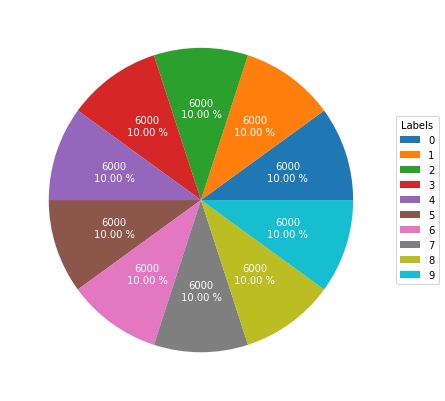

In [5]:
dat = Create_Array(train, 1, 123)
_ = dat.get_pie_chart(figsize=(10,7))

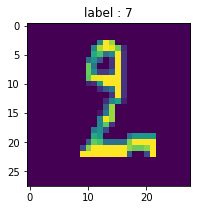

In [6]:
_ = dat.show_one_image(figsize=(3,3))

In [7]:
#dat.show_multiple_images(figsize=(12,7), seed=933)

In [8]:
dat.split_data(test_size=0.2, to_category=False)

100% |########################################################################|
100% |########################################################################|


In [9]:
print(dat.train_X.shape)
print(dat.test_X.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)


# Create model of cnn

In [10]:
def history_plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.grid(True)
    
    #plt.figure()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(True)
    
    #plt.show()
    return plt

In [11]:
# Confusion matrix
def get_confusion_matrix(Y, y_pred, figsize=(7,7), dpi=90, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        cnf_matrix = confusion_matrix(Y, y_pred)
        
        if normalize:
            cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
        
        plt.figure(figsize=figsize, dpi=dpi)
        plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(5)
        plt.xticks(tick_marks, [0,1,2,3,4], rotation=0)
        plt.yticks(tick_marks, [0,1,2,3,4])
        
        fmt = '.2f' if normalize else 'd'
        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cnf_matrix[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return plt

In [12]:
# # Importing the required Keras modules containing model and layers
# from keras.models import Sequential
# from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
# # Creating a Sequential Model and adding the layers
# model = Sequential()
# model.add(Conv2D(28, kernel_size=(3,3), input_shape=(28,28,1)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(56, kernel_size=(3,3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
# model.add(Dense(128, activation=tf.nn.relu))
# model.add(Dropout(0.4))
# model.add(Dense(10,activation=tf.nn.softmax))

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
# Creating a Sequential Model and adding the layers
model = Sequential()

model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [32]:
# Reshaping the array to 4-dims so that it can work with the Keras API
#x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
#x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = dat.train_X
x_test = dat.test_X
y_train = dat.train_y
y_test = dat.test_y
input_shape = (1, 28, 28)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (48000, 28, 28, 1)
Number of images in x_train 48000
Number of images in x_test 12000


In [33]:
def fit_model(model, epoch):
    model.compile(optimizer="adam",
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                        nb_epoch=epoch,
                        validation_data=(x_test, y_test),
                        verbose=1)
    return model, history

In [ ]:
model, history = fit_model(model=model, epoch=10)

C:\Users\hazrak\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 1120/48000 [..............................] - ETA: 47:20 - loss: 1.6641 - acc: 0.4938

In [ ]:
_ = history_plot(history)

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
model.summary()

In [ ]:
model.get_layer('flatten_1').output
model.input

In [ ]:
from keras import models
from keras.models import Model
from keras.models import load_model

model_ = models.Sequential()
model_.add(Model(inputs=model.input, outputs=model.get_layer('flatten_1').output))

In [ ]:
model_.predict(x=dat.data.drop(columns="label").values.reshape(60000, 28, 28).reshape(60000, 28, 28, 1)).shape

In [ ]:
predicted_features = model_.predict_proba(dat.data.drop(columns="label").values.reshape(60000, 28, 28).reshape(60000, 28, 28, 1))
predicted_label = model.predict_classes(dat.data.drop(columns="label").values.reshape(60000, 28, 28).reshape(60000, 28, 28, 1))

In [ ]:
_ = get_confusion_matrix(Y=dat.data.label.values, y_pred=predicted_label, normalize=False, dpi=75, figsize=(6,6))

# Prediction of features from cnn model

In [13]:
class Model_Multiclass:
    def __init__(self,data,seed,random_sample):
        self.random_sample = random_sample
        self.seed = seed
        self.data = data.sample(frac=self.random_sample, replace=False, random_state=self.seed)
    def split(self, test_size):
        self.test_size = test_size
        train_X, test_X, train_y, test_y = train_test_split(self.data,self.data['target'], test_size = test_size, random_state=self.seed)
        self.train_X = train_X.drop(columns=['target'])
        self.test_X = test_X.drop(columns=['target'])
        self.train_y = train_y
        self.test_y = test_y
    def model_LR(self,n_jobs,cv,regul,param_grid):
        self.regul = regul
        if regul=='none':
            model = linear_model.SGDClassifier(loss='log', random_state=0, penalty=self.regul)
            grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', n_jobs=n_jobs, cv=cv, verbose=1)
            grid.fit(self.train_X,self.train_y)
            self.grid = grid
        elif regul=='elasticnet':
            model = linear_model.SGDClassifier(loss='log', random_state=0, penalty=self.regul,max_iter=5000)
            grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', n_jobs=n_jobs, cv=cv, verbose=1)
            grid.fit(self.train_X,self.train_y)
            self.grid = grid
    def model_GB(self,n_jobs,cv,param_grid):
        model = ensemble.GradientBoostingClassifier()
        grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', n_jobs=n_jobs, cv=cv, verbose=1)
        grid.fit(self.train_X,self.train_y)
        self.grid = grid
    def model_KNN(self,n_jobs,cv,param_grid):
        model = neighbors.KNeighborsClassifier()
        grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', n_jobs=n_jobs, cv=cv, verbose=1)
        grid.fit(self.train_X,self.train_y)
        self.grid = grid
    def model_RF(self,n_jobs,cv,param_grid):
        model = ensemble.RandomForestClassifier()
        grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', n_jobs=n_jobs, cv=cv, verbose=1)
        grid.fit(self.train_X,self.train_y)
        self.grid = grid
    def predict(self):
        self.pred_train = self.grid.best_estimator_.predict(X=self.train_X)
        self.pred_test = self.grid.best_estimator_.predict(X=self.test_X)
    ### get contingency table + recall precision + roc curve !!!
    def confusion(self,set_):
        if set_ == "train":
            res = metrics.confusion_matrix(y_true=self.train_y,y_pred=self.pred_train)
        elif set_ == "test":
            res = metrics.confusion_matrix(y_true=self.test_y,y_pred=self.pred_test)
        return res
    def getAccuracy(self):
        res=(metrics.accuracy_score(y_true=self.train_y,y_pred=self.pred_train),
            metrics.accuracy_score(y_true=self.test_y,y_pred=self.pred_test))
        return res

In [134]:
# get features from cnn
dat_features = model_.predict(x=dat.data.drop(columns="label").values.reshape(60000, 28, 28).reshape(60000, 28, 28, 1))

In [135]:
dat_features_df = pd.DataFrame(data=dat_features, columns=["f"+str(f) for f in range(dat_features.shape[1])])
dat_features_df["target"] = dat.data["label"]
dat_features_df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f341,f342,f343,f344,f345,f346,f347,f348,f349,target
0,-0.13509,-0.160364,-0.250591,-0.288963,-0.385382,0.004082,-0.015994,-0.382615,-0.302828,-0.144999,...,-14.063784,6.479705,240.675049,-54.391491,56.767456,2.470936,6.825625,167.088318,15.571436,0
1,-0.13509,-0.160364,-0.250591,-0.288963,-0.385382,0.004082,-0.015994,-0.382615,-0.302828,-0.144999,...,192.262329,-14.244569,563.911499,73.047920,151.072128,-18.337658,3.003354,70.379250,35.705208,1
2,-0.13509,-0.160364,-0.250591,-0.288963,-0.385382,0.004082,-0.015994,-0.382615,-0.302828,-0.144999,...,144.073456,245.908234,19.961300,270.315979,10.954406,-66.891533,89.689415,226.416473,23.538467,2
3,-0.13509,-0.160364,-0.250591,-0.288963,-0.385382,0.004082,-0.015994,-0.382615,-0.302828,-0.144999,...,0.004082,-0.015994,62.841129,-0.302828,402.546997,116.740067,227.808563,0.065446,76.343040,3
4,-0.13509,-0.160364,-0.250591,-0.288963,-0.385382,0.004082,-0.015994,-0.382615,-0.302828,-0.144999,...,0.004082,10.549805,-0.382615,-0.302828,40.766087,12.286865,-0.079779,87.579750,38.475342,4


In [14]:
dat_features_df = pd.read_pickle("../data/data_cnn.pkl")

In [15]:
lr = Model_Multiclass(data=dat_features_df,seed=123,random_sample=1)
lr.split(test_size=0.2)
lr.data.shape

(60000, 1025)

In [16]:
param_grid = {"alpha": np.logspace(-2, 0.1, 2),
              "l1_ratio": np.array([0, 0.3, 0.5, 0.7, 1])}
lr.model_LR(n_jobs=40,cv=3,regul="elasticnet",param_grid=param_grid)
lr.predict()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  13 out of  30 | elapsed: 189.0min remaining: 247.2min
[Parallel(n_jobs=40)]: Done  30 out of  30 | elapsed: 319.5min finished
C:\Users\hazrak\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [18]:
lr.grid.best_params_

{'alpha': 1.2589254117941673, 'l1_ratio': 0.0}

In [19]:
lr.getAccuracy()

(0.9981458333333333, 0.9965833333333334)

In [22]:
pd.to_pickle(lr.grid, "model_lr.pkl")

# test : cnn, cnn+lr on a sample 50%

In [86]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [87]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


In [89]:
# Importing the required Keras modules containing model and layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

In [90]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 13s 222us/step - loss: 0.2150 - acc: 0.9345
Epoch 2/10
 7712/60000 [==>...........................] - ETA: 10s - loss: 0.0933 - acc: 0.9721

KeyboardInterrupt: 